In [1]:
%matplotlib inline

import os

import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

SAMPLE = 'http://proalki.uni-leipzig.de/wiki/Project:Portmanteau_Analyses'
SAMPLE_CSV = 'portmanteau_sample.csv'
RENAME = {'Quechua (Ayacucho)': 'Quechua', 'Tlachichilco Tepehuan': 'Tepehuan'}

if not os.path.exists(SAMPLE_CSV):
    sf, = pd.read_html(SAMPLE, header=0, index_col='Language')
    sf.to_csv(SAMPLE_CSV, encoding='utf-8')

sf = pd.read_csv(SAMPLE_CSV, encoding='utf-8')
sf = sf.rename(columns={'Languoid': 'Family'})
sf['Language'] = sf['Language'].replace(RENAME)
sf = sf.set_index('Language')
sf.info()
assert sf.index.is_unique

<class 'pandas.core.frame.DataFrame'>
Index: 30 entries, Ainu to Yimas
Data columns (total 11 columns):
Family        30 non-null object
LID           29 non-null float64
LOID          30 non-null int64
Continent     30 non-null object
Area          30 non-null object
Analysis      29 non-null object
Forms         30 non-null object
Elim          1 non-null object
Status        30 non-null object
Comments      8 non-null object
Impression    22 non-null object
dtypes: float64(1), int64(1), object(9)
memory usage: 2.8+ KB


In [2]:
df = sf.loc[sf['Status'] == 'ready', :'Analysis'].drop('LOID', axis=1)
df['LID'] = df['LID'].fillna(0, downcast='infer')
df.head()

,Family,LID,Continent,Area,Analysis
Language,,,,,
Ainu,Ainu,12,N-C Asia,N Coast Asia,Ain/Paradigms/to X
Aleut,Aleut,18,N-C Asia,N Coast Asia,Ale/Paradigms/to X
Bella Coola,Bella Coola,995,W N America,Alaska-Oregon,Blc/Paradigms/to X
Chuckchi,Chukotkan,56,N-C Asia,N Coast Asia,Ckt/Paradigms/to X
Darai,Indo-Iranian,1399,S/SE Asia,Indic,Dry/Paradigms/to all/Npst


In [3]:
AUTOTYP = 'http://www.autotyp.uzh.ch/download/release_2013/autotyp.csv'
AUTOTYP_CSV = AUTOTYP.rpartition('/')[2]
AUTOTYP_FORMAT = {
    'encoding': 'utf-8',
    'na_values': '', 'keep_default_na': False,
    'index_col': 'LID'
}

if not os.path.exists(AUTOTYP_CSV):
    af = pd.read_csv(AUTOTYP, **AUTOTYP_FORMAT)
    af.to_csv(AUTOTYP_CSV, encoding=AUTOTYP_FORMAT['encoding'])

af = pd.read_csv(AUTOTYP_CSV, **AUTOTYP_FORMAT)
af.info()
assert af.index.is_unique

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2913 entries, 199 to 3213
Data columns (total 15 columns):
ISO639.3             2846 non-null object
language             2913 non-null object
alt.language.name    2873 non-null object
language.search      2913 non-null object
lsbranch             301 non-null object
ssbranch             529 non-null object
sbranch              1322 non-null object
mbranch              2070 non-null object
stock                2913 non-null object
alt.stock.name       366 non-null object
stock.search         2913 non-null object
longitude            2913 non-null float64
latitude             2913 non-null float64
area                 2913 non-null object
continent            2913 non-null object
dtypes: float64(2), object(13)
memory usage: 364.1+ KB


In [4]:
af['family'] = af['mbranch'].fillna(af['stock'])
af['family'].value_counts().head()

Malayo-Polynesian    326
Bantoid              164
Indo-Iranian         109
West Semitic          51
Germanic              50
Name: family, dtype: int64

In [5]:
JUM = pd.Series({  # missing in autotyp
    'ISO639.3': 'jum', 'family': 'Western Nilotic',
    'continent': 'Africa', 'area': 'African Savannah',
    'longitude': 33.7494, 'latitude': 10.4349,
})

jf = df[['LID']].reset_index().set_index('LID').join(af).set_index('Language')
jf = jf[['ISO639.3', 'family', 'continent', 'area', 'latitude', 'longitude']]
jf.loc['Jumjum'] = JUM
assert jf.notnull().all().all()
jf.head()

,ISO639.3,family,continent,area,latitude,longitude
Language,,,,,,
Ainu,ain,Ainu,N-C Asia,N Coast Asia,43.0,143.00
Aleut,ale,Aleut,N-C Asia,N Coast Asia,54.0,-166.00
Bella Coola,blc,Salishan,W N America,Alaska-Oregon,52.5,-126.67
Chuckchi,ckt,Chukotkan,N-C Asia,N Coast Asia,67.0,170.00
Darai,dry,Indo-Iranian,S/SE Asia,Indic,24.0,84.00


In [6]:
pd.merge(jf, af.groupby('area').size().to_frame('n'),
    left_on='area', right_index=True).sort_values(['continent', 'area'])\
    .drop(['latitude', 'longitude'], axis=1)

,ISO639.3,family,continent,area,n
Language,,,,,
Jumjum,jum,Western Nilotic,Africa,African Savannah,375
Kunama,kun,Kunama,Africa,Greater Abyssinia,61
Turkana,tuv,Eastern Nilotic,Africa,S Africa,190
Maung,mph,Iwaidjan,Australia,N Australia,108
Wardaman,wrr,Wagiman - Wardaman,Australia,N Australia,108
Tepehuan,tee,Totonac-Tepehuan,C America,Mesoamerica,173
Lakhota,lkt,Siouan,E N America,Basin and Plains,68
Maricopa,mrc,Yuman,E N America,Basin and Plains,68
Fox,sac,Algonquian,E N America,E North America,69


In [7]:
pd.merge(af.groupby(['area', 'continent'], as_index=False)['language'].count(),
    jf[['area']].reset_index(), how='left', on='area').set_index(['continent', 'area'])\
    .query('Language != Language')

language Language
continent        area                                  
W and SW Eurasia Europe                    142      NaN
                 Greater Mesopotamia       131      NaN
NG and Oceania   Interior New Guinea        81      NaN
Africa           N Africa                   28      NaN
Australia        S Australia                81      NaN
NG and Oceania   S New Guinea               67      NaN
S America        SE South America           32      NaN

In [8]:
af[['family', 'continent', 'area']].apply(lambda x: x.nunique())

family       593
continent     10
area          24
dtype: int64

In [9]:
jf[['family', 'continent', 'area']].apply(lambda x: x.nunique())

family       26
continent     9
area         17
dtype: int64

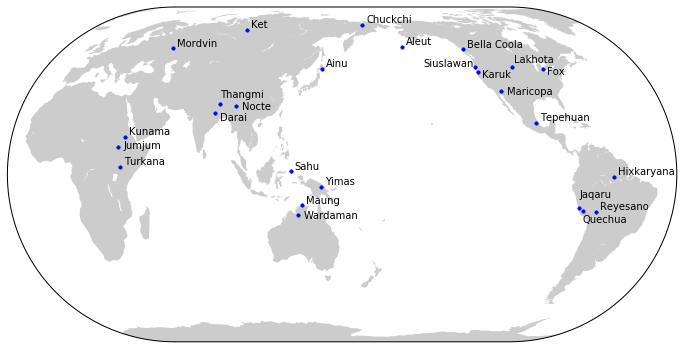

In [10]:
fig, ax = plt.subplots(figsize=(12, 6))
m = Basemap(ax=ax, projection='eck4', lon_0=155)
m.fillcontinents()
#m.drawparallels(range(-90, 120, 30), dashes=[], linewidth=.25, labels=[1, 0, 0, 0])
#m.drawmeridians(range(0, 360, 60), dashes=[], linewidth=.25, labels=[0, 0, 0, 1])
offsets = {
    'Jumjum': (3e5, -1e5),
    'Thangmi': (0, 3e5), 'Nocte': (3e5, -2e5), 'Darai': (3e5, -4e5),
    'Wardaman': (3e5, -2e5),
    'Siuslawan': (-2.6e6, 0), 'Karuk': (2e5, -3e5), 'Maricopa': (3e5, -2e5),
    'Lakhota': (1e5, 2e5), 'Fox': (2e5, -3e5),
    'Jaqaru': (0, 5e5), 'Quechua': (0e5, -6e5),
}
for l, (x, y) in jf[['longitude', 'latitude']].iterrows():
    x, y = m(x, y)
    m.plot(x, y, marker='.', color='b', markersize=7)
    xoff, yoff = offsets.get(l, (2e5, 1e5))
    ax.text(x + xoff, y + yoff, l)
#fig.savefig('map.pdf', bbox_inches='tight', pad_inches=.01)